# Iris in ML-Flow - Basic example to start using MLFlow to log experiments

---

## We load the standard Iris dataset, and use a basic `SVM` and a `XGBoost` to classify the flowers

- don't focus on the specifics of the models used - this is merely an example to show how to log parameters and metrics

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris

iris_data = load_iris()

iris = pd.DataFrame(iris_data['data'], columns=iris_data['feature_names'])
iris_target = pd.DataFrame(iris_data['target'], columns=["type"])
iris.head()

sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                5.1               3.5                1.4               0.2
1                4.9               3.0                1.4               0.2
2                4.7               3.2                1.3               0.2
3                4.6               3.1                1.5               0.2
4                5.0               3.6                1.4               0.2

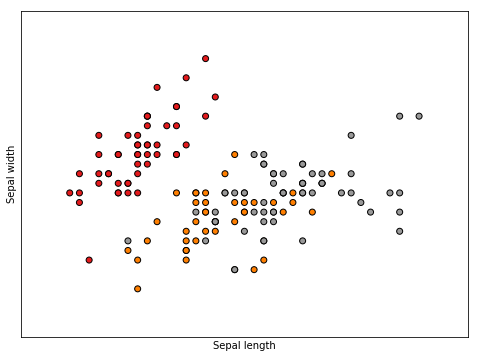

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.decomposition import PCA

X = iris_data.data[:, :2]
y = iris_data.target

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

plt.figure(2, figsize=(8, 6))
plt.clf()

# Plot the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1,
            edgecolor='k')
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())


plt.show()

## Install and setup `MLflow`

In [3]:
%%capture install_mlflow
!pip install mlflow

In [4]:
import mlflow

### MLFlow needs to track its runs - we have setup a Tracking Server

Read
https://www.mlflow.org/docs/latest/tracking.html#where-runs-are-recorded

For this example, we used https://www.mlflow.org/docs/latest/tracking.html#tracking-server

Feel free to use this public `tracking_uri` to test out this notebook and try out if you can log some parameters and metrics

In [ ]:
mlflow.set_tracking_uri("http://mlflowui.mybluemix.net:80")

## An `experiment` is a group of `run`s

- Within an `experiment` you can try different model types, all with different parameters / features. 
- A `experiment` contains `runs`.
- `runs` can be nested, usually to group similar runs together.

https://www.mlflow.org/docs/latest/python_api/mlflow.html#mlflow.start_run

## Example 1 - Iris Classification with a SVM

In [ ]:
from sklearn import svm, datasets
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix

In [ ]:
mlflow.start_run(experiment_id=2, run_name="iris_svm", nested=True)

clf = svm.SVC(gamma="auto", degree=2, C=6.0)

cv_scores = cross_val_score(clf,iris.values,iris_target.values.ravel(),cv=3)
cv_preds = cross_val_predict(clf,iris.values,iris_target.values.ravel(),cv =3)

### Most/All `sklearn` model objects will tell you its parameters with `get_params()`

...And, `MLFlow` is happy to log them all for you with a simple `mlflow.log_params()`

(not to be confised with `mlflow.log_param()`)


In [ ]:
# sklearn, is happy to show you the parameters you trained your model with...

clf.get_params()

In [ ]:
cv_scores.mean()

In [ ]:
from mlflow import log_metric, log_param, log_params, log_metrics

log_params(clf.get_params())
log_metric("cv_scores_mean", cv_scores.mean())

In [ ]:
mlflow.end_run()

## 7 lines of code were added 
*Is it worth it, lemme log it - I log my metrics, params, and reverse it!*

- 3 lines to import `mlflow` and setup the tracking uri
- 1 line to start/continue a run in mlflow with `mlflow.start_run()`
- 1 line to log all parameters with `log_params()`
- 1 line to log the metric of the CV with `log_metric()`
- 1 line to end out experiment with `end_run()`

**Repeat a new run with different parameters will only require 3 more lines**

## Example 2 - Iris with XGBoost

In [ ]:
X = iris_data.data
y = iris_data.target

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

### For `XGBoost`, it is common to create a dictionairy for the parameters

and again we can log them all to `MLFlow` with a oneliner.

In [ ]:
params = {
    'objective' : 'multi:softprob',
    'min_child_weight' : 2,
    'num_class' : 3,
    'eta' : 0.01,
    'seed' : 0,
    'gamma':0,
    'max_depth': 2,
    'nthread' : 1,
    # 'colsample_bytree': 0.7,
    # 'subsample':0.7,
    "silent" : True,
}

hist = xgb.cv(params, dtrain, as_pandas=True, nfold=3, num_boost_round=10, verbose_eval=1, early_stopping_rounds=10, show_stdv=True, seed=0)

In [ ]:
mlflow.start_run(experiment_id=2, run_name="iris_xgboost", nested=True)

In [ ]:
mlflow.log_params(params)

### For XGBoost and Neural-Nets, you might be interested in the learning graphs - which can be logged & plotted for each step

For a SVM, there is not really a learning process we might want to keep track off. XGBoost and Deeplearning do have them.

In [ ]:
for step in hist.index:
    mlflow.log_metrics(hist.iloc[step].to_dict(), step=step)
    

In [ ]:
mlflow.end_run()